# **Temat projektu**
Tematem projektu jest wykrywanie oszustw na podstawie danych. Model określa czy dana transakcja jest prawdziwa, czy fałszywa.


## **0a. Dane**
Dane pochodzą ze strony https://www.kaggle.com/datasets/joebeachcapital/credit-card-fraud?resource=download.

Zbiór danych zawiera transakcje dokonane za pomocą kart kredytowych we wrześniu 2013 roku przez europejskich posiadaczy kart. Zawiera transakcje z dwóch dni, w których odnotowano 492 przypadki oszustw na łączną liczbę 284 807 transakcji. Zbiór danych jest silnie niezrównoważony – klasa pozytywna (oszustwa) stanowi jedynie 0,172% wszystkich transakcji.

In [1]:
# Wczytywanie danych i bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/creditcard_csv.csv")

## **0b. Wstęp**

Pierwszy milestone zawiera w sobie: \
&emsp;    **1.** Wyznaczenie celu biznesowego i problemowego i zdefiniowanie miary sukcesu \
&emsp;    **2.** Podział danych na zbiór treningowy, walidacyjny i testowy \
&emsp;    **3a**. Eksploracja i wstępna analiza danych \
&emsp;    **3b.** Wstępne przetwarzanie danych \
&emsp;    **4.** Wartości odstające \
&emsp;    **5.** Balansowanie danych 




## 1. Wyznaczenie celu biznesowego i problemowego i zdefiniowanie miary sukcesu


W naszym zbiorze danych klasa pozytywna (oszustwa) stanowi jedynie 0,172% wszystkich danych. Co za tym idzie, nasz model osiągnął by wysoką dokładność, gdyby **wszystko przewidywał jako nieoszustwo.** \
\
Oby ocenić skuteczność wykrywania oszustw oraz koszt błędów, będziemy korzystać z miar **AUC-ROC** oraz **F1-score**. 

Ze względu na to, że każde **oszustwo wiąże się ze stratą banku**, to odpowiednie przewidywanie czy dana transakcja jest oszustwem czy też nie jest kluczowa. Dlatego też dodatatkowo na podstawie popełnionych przez model błędów (FN,FP) określimy ile błędy popełnione przez model kosztują będą kosztować banki.

Koszty FN to będize średnia kwota oszustw na podstawie **Amount** dla klasy **1**, a FP to będzie koszt weryfikacji - przyjmiemy **5zł**. Miary sukcesu **AUC-ROC** wybrano, aby zbilansować wykrywanie oszustw. 

## 2. Podział danych
Zbiór treningowy będzie stanowił 70% zbioru i razem z walidacyjnym będzie stanowić 85%. Walidacja krzyżowa polega na trenowaniu modelu na obu tych zbiorach. Więc zrobimy podział w proporcji 85:15

In [3]:
# cechy zabieramy
X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})

# dzielimy
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

print("Kolumny w X_train_valid:", X_train_valid.columns.tolist())
print("Rozmiar X_train_valid:", X_train_valid.shape)
print("Rozmiar y_train_valid:", y_train_valid.shape)

Kolumny w X_train_valid: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Rozmiar X_train_valid: (242085, 30)
Rozmiar y_train_valid: (242085,)


In [4]:
print("Rozkład klas w y_train_valid:", y_train_valid.value_counts(normalize=True))
print("Rozkład klas w y_test:", y_test.value_counts(normalize=True))

Rozkład klas w y_train_valid: Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Rozkład klas w y_test: Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


## **3a. Eksploracja i wstępna analiza danych**

Kolumny V1-V28 to cechy zanonimizowane po PCA, Time to czas od pierwszej transakcji, Amount to kwota transakcji.

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [7]:
df.shape

(284807, 31)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Możemy stwierdzić brak pustych wartości.

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


### Kolumna 'Class'

In [10]:
df['Class'].value_counts()

Class
'0'    284315
'1'       492
Name: count, dtype: int64

In [13]:
492/(492+284315)*100

0.1727485630620034

Działamy na silnie niezrównoważonym zbiorze

### Pozostałe kolumny

Spójrzmy jak wygląda rozkład wartości pozostałych kolumn z podziałem na wartość 'Class'.

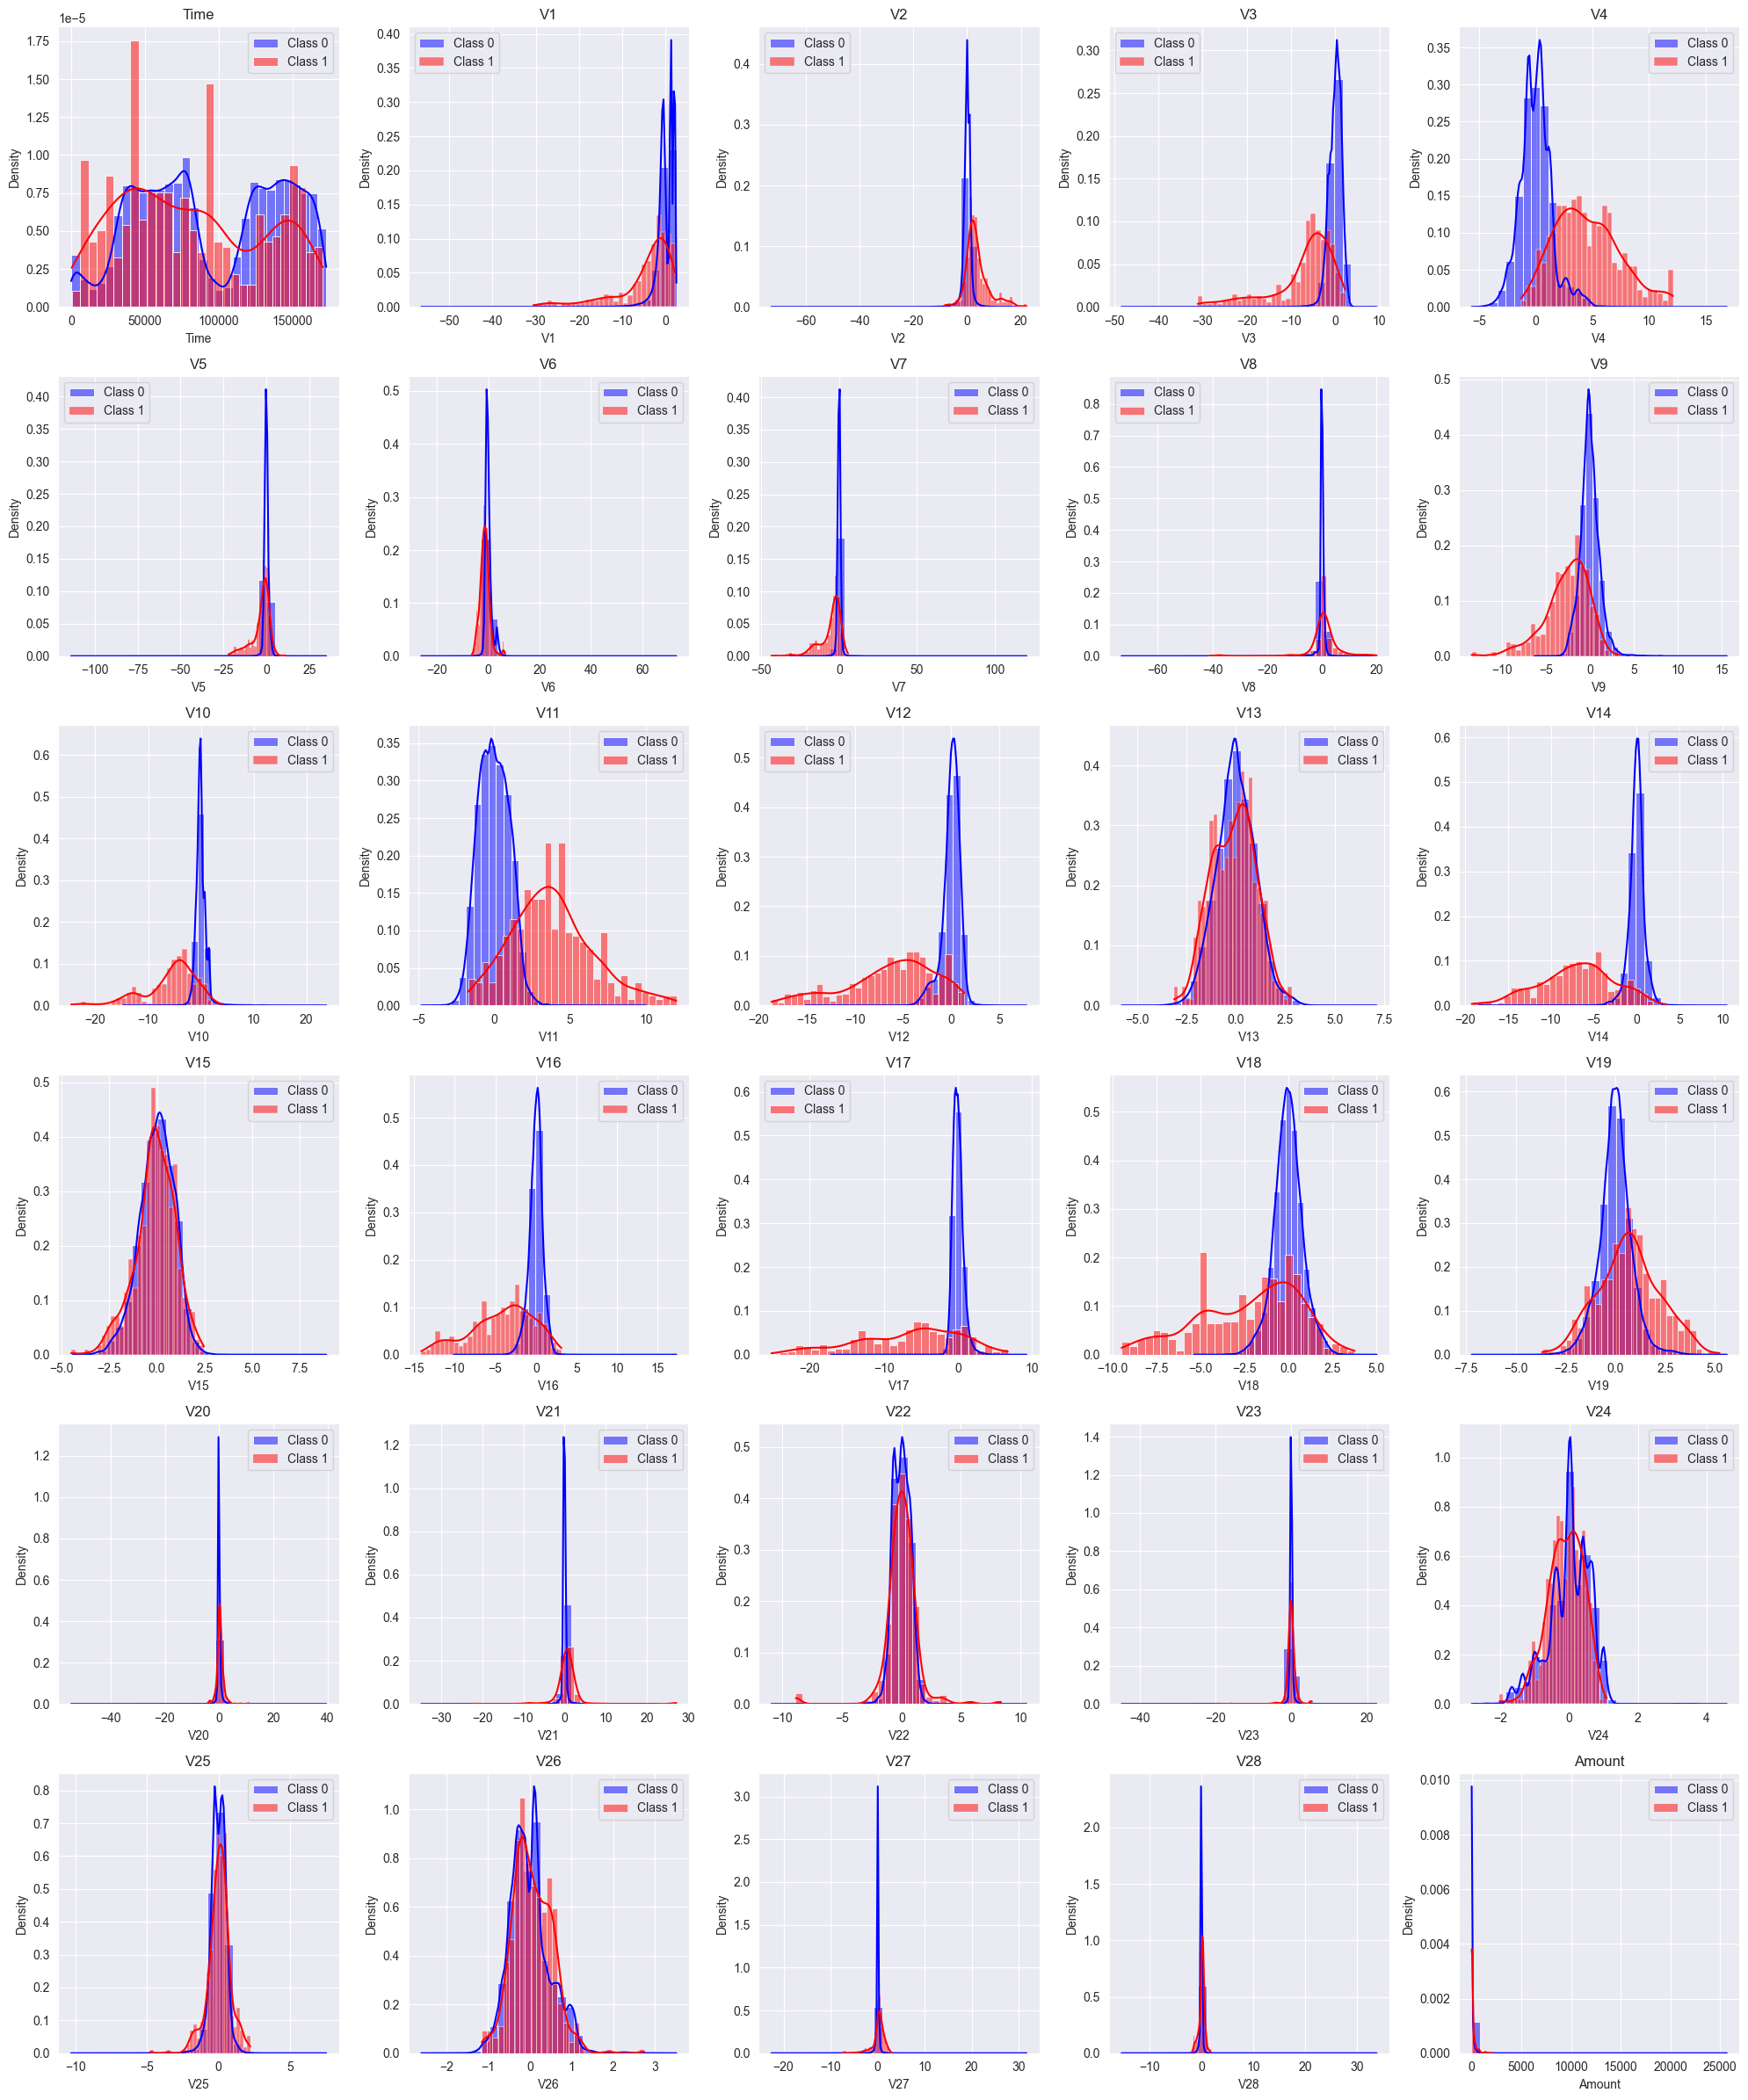

In [14]:
num_columns = df.columns[:-1]  # Kolumny feature
class_column = df.columns[-1]  # Kolumna 'Class'

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    ax = axes[i]
    sns.histplot(df[df[class_column] == "'0'"][col], bins=30, kde=True, stat='density', color='blue', label='Class 0',
                 ax=ax, alpha=0.5)
    sns.histplot(df[df[class_column] == "'1'"][col], bins=30, kde=True, stat='density', color='red', label='Class 1',
                 ax=ax, alpha=0.5)

    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.show()

## Test Kołmogorowa-Smirnova

Wykonujemy test statystyczny w celu sprawdzenia czy dane podzielone na 'Class' pochodzą z tego samego rozkładu

In [28]:
from scipy.stats import ks_2samp

ks_results = {}

for col in num_columns:
    class_0_data = df[df[class_column] == "'0'"][col]
    class_1_data = df[df[class_column] == "'1'"][col]

    # Test KS
    ks_stat, p_value = ks_2samp(class_0_data, class_1_data)

    ks_results[col] = {"KS Statistic": ks_stat, "p-value": p_value}

ks_df = pd.DataFrame.from_dict(ks_results, orient='index')

ks_df.sort_values(by='p-value', ascending=False, inplace=True)

ks_df.head(10)

,KS Statistic,p-value
V22,0.057858,7.180676e-02
V15,0.063414,3.688624e-02
V25,0.088129,9.097462e-04
V26,0.090769,5.702418e-04
V13,0.103119,5.338334e-05
V24,0.129193,1.323582e-07
Time,0.169389,8.733229e-13
V23,0.181940,1.074846e-14
Amount,0.271192,2.170305e-32
V19,0.334682,1.538527e-49


Możemy twierdzić, że dane podzielone ze względu na 'Class' pochodzą z innego rozkładu.

## 3b. Przetwarzanie danych

### Kolumny V1-V28

Niestety ze względów poufności nie wiemy co dokładnie przedstawiają te kolumny.

Dane liczbowe w kolumnach V1,V2,...,V28 są po przekształceniach PCA [(Principal content analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis). Dzięki temu te kolumny są od siebie niezależne, co możemy zilustrować za pomocą macierzy kowariancji.

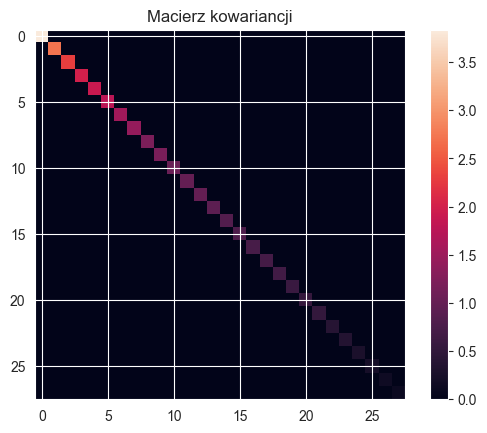

In [18]:
plt.imshow(df.filter(regex='^V').cov())
plt.title('Macierz kowariancji')
plt.colorbar()
plt.show()

## Kolumna Time


<Axes: xlabel='Class', ylabel='Time'>

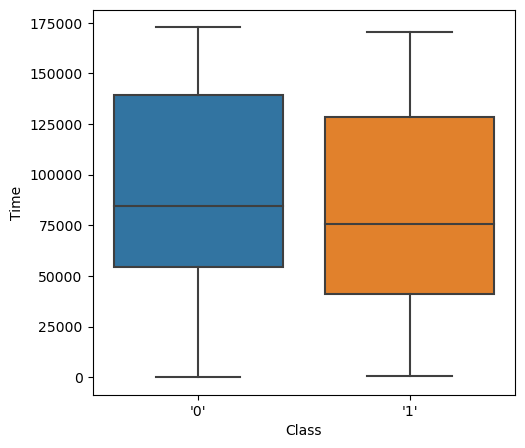

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Time', data=df)

Dane pochodzą z okresu dwóch dni, a wartość 'Time' to liczba sekund, jaka upłynęła od pierwszej transakcji w naszym zbiorze.

Zakładając, że wartość 'Time' = 0 oznacza godzinę 0:00:00, możemy przekształcić wartości w kolumnie tak, aby przedstawiały porę dnia, o której odbyła się transakcja. Wtedy rozkład ze względu na wartość 'Class' prezentuje się następująco.

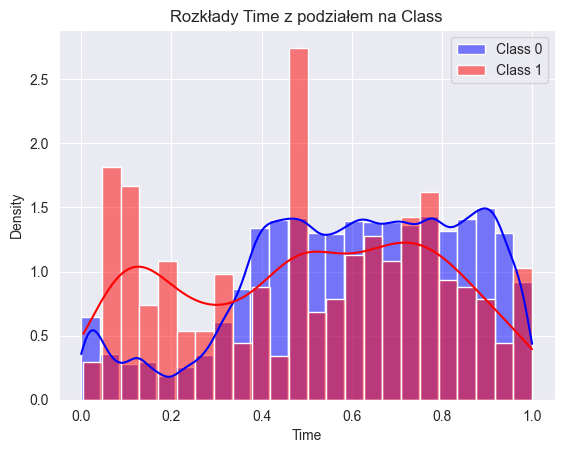

In [19]:
# % (24*60*60) /(60*60*24) to modulo liczba sekund w jednym dniu i przekształcone do jednostki w dniach
# przekształcone do dni, aby zmiescic sie w przedziale [0, 1)
sns.histplot(df[df[class_column] == "'0'"]['Time'] % (24*60*60) /(24*60*60), bins=24, kde=True, stat='density', color='blue', label='Class 0', alpha=0.5)
sns.histplot(df[df[class_column] == "'1'"]['Time'] % (24*60*60) /(24*60*60), bins=24, kde=True, stat='density', color='red', label='Class 1', alpha=0.5)

plt.title('Rozkłady Time z podziałem na Class')
plt.legend()
plt.show()

In [22]:
# Test KS

class_0_data = df[df[class_column] == "'0'"]['Time'] % (24*60*60) /(24*60*60)
class_1_data = df[df[class_column] == "'1'"]['Time'] % (24*60*60) /(24*60*60)

# Test KS
ks_stat, p_value = ks_2samp(class_0_data, class_1_data)

#print(ks_stat)
print(p_value)

3.667416587732577e-17


Dzięki takiemu przekształceniu możemy nadać wartości 'Time' większy sens. 
Dodatkowo nasz model zyska na poszerzeniu swojego zastosowania o wskazywanie potencjalnych oszustw wykonanych w również inne dni.

### Kolumna Amount

Kolumna ta odpowiada za wartość transakcji. Przedstawmy nasze dane za pomocą boxplotu.

<Axes: xlabel='Class', ylabel='Amount'>

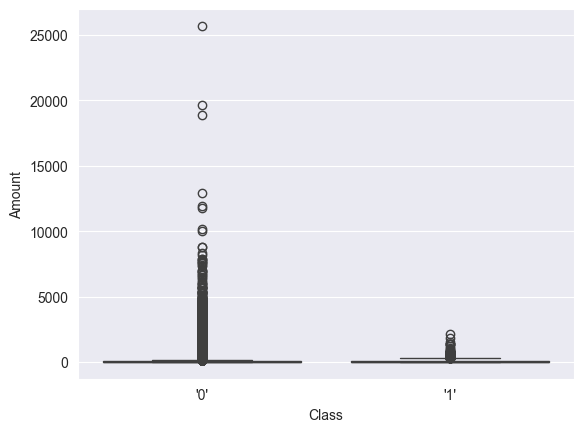

In [24]:
sns.boxplot(x='Class', y='Amount', data=df)  # x='Class' do podziału

(0.0, 2000.0)

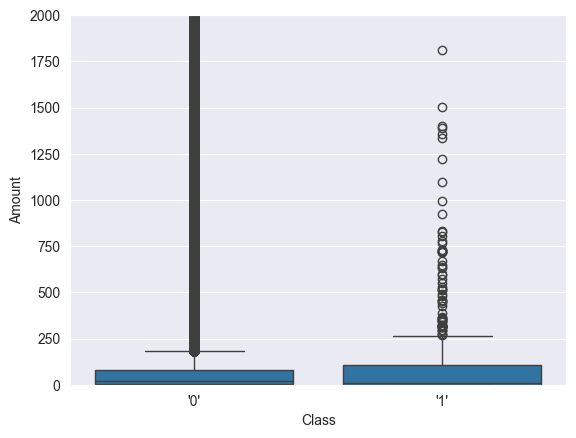

In [25]:
sns.boxplot(x='Class', y='Amount', data=df)

# Ograniczenie osi Y
plt.ylim(0, 2000)

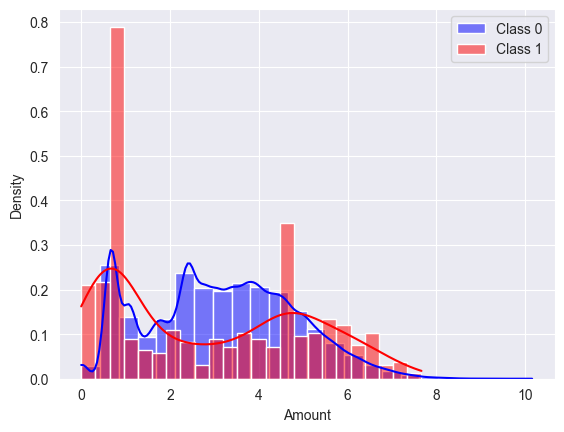

In [26]:
# nakładamy np.log1p na wartosci amount i przedstawiamy na histogramie
sns.histplot(np.log1p(df[df[class_column] == "'0'"]['Amount']), bins=24, kde=True, stat='density', color='blue', label='Class 0', alpha=0.5)
sns.histplot(np.log1p(df[df[class_column] == "'1'"]['Amount']), bins=24, kde=True, stat='density', color='red', label='Class 1', alpha=0.5)

plt.legend()
plt.show()

In [31]:
# Test KS

class_0_data = np.log1p(df[df[class_column] == "'0'"]['Amount'])
class_1_data = np.log1p(df[df[class_column] == "'1'"]['Amount'])

# Test KS
ks_stat, p_value = ks_2samp(class_0_data, class_1_data)

#print(ks_stat)
print(p_value) # wynik taki sam jak wyżej, bo dystrybuanta empiryczna się nie zmienia

2.1703053464297746e-32


## 4. Wartości odstające

Aby wiedzieć, co z nimi zrobić, należy zobaczyć jak duża część z nich jest oszustwami zarówno dla **Time** jak i **Amount**. Na wykresach wyżej można było zauważyć, że duża część z tych outlierów należy do klasy oszustw. Zatem usunięcie danych może być złym pomysłem.

Zmienne Amount oraz Time zostaną **znormalizowane**, ponieważ ze względud na dużą ilość outlierów **winsoryzacja** znacząco zaburzy ich rozkład.

## 5. Balansowanie danych

Zastosowanie SMOTE do balansowania klas w zbiorze treningowym - **proponuję Oversampling** (dodajemy oszustwa do zbioru trenignowego)